# Maven Healthcare Challenge

This project is my submission for the [Maven Healthcare Challenge](https://mavenanalytics.io/challenges/maven-healthcare-challenge/26). My goal is to analyze the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey data and determine if it was able to improve quality of care and service to patients. 

The HCAHPS survey is required by the Centers for Medicare and Medicaid Services (CMS) for all hospitals in the United States and is used to measure patients' perspectives on hospital care. The results are made public to encourage hospitals to improve their quality of care and service to patients, and to empower patients to make informed decisions about where they receive care.

## Overview
- **Exploratory data analysis**: Initial dataset review and cleaning; identify and address data quality issues.
- **National Level Analysis**: Analyze national trends in patient satisfaction.
- **State Level Analysis**: Analyze state level trends in patient satisfaction.
- **Response Rate Analysis**: Evaluate trends in response rates.
- **Recommendations**: Recommendations for improving patient satisfaction.

## Exploratory Data Analysis
For this project I analyzed the data using a top-down approach. I started with a broad level analysis of national data, then moved down to a more detailed evaluation of state and response data. For all datasets, I converted the `release_period` column show only the year as an integer. All column headers were also converted to lowercase for ease of use. 

- **National Data**: 5 columns, 90 rows
  - The dataset contained the measure ID and corresponding top, middle, and bottom box percentage from 2015 to 2023. 
  - The national and measures data were merged to have a description for each measure.
- **State Data**: 6 columns, 4580 rows
  - The dataset contained the measure ID and corresponding top, middle, and bottom box percentage from 2015 to 2023 for each state.
  - Missing data for Maryland 2016 was interpolated by calculating the mean of 2015 and 2017 data. 
  - The states table was merged with the dataset to include the state name and region. 
  - Filtered dataset to include only data with the measure ID 'H_RECMND' and calculated NPS.
- **Response Data**: 5 columns, 43219 rows
  - The dataset contained the response rate of patients that completed the HCAHPS survey for each hospital in each state from 2015 to 2023.
  - 5 additional states (PR, VI, GU, MP, AS) corresponding to the unincorporated US territories were removed from the dataset. 


In [6]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

In [21]:
# Load national results into dataframe
national_results = pd.read_csv('data_tables/national_results.csv')

# Convert release period to datetime
national_results['Release Period'] = pd.to_datetime(
    national_results['Release Period'].str.lstrip('07_')).dt.year
national_results.columns = national_results.columns.str.lower().str.replace(' ', '_')

# Load measures into dataframe
measures = pd.read_csv('data_tables/measures.csv')
measures.columns = measures.columns.str.lower().str.replace(' ', '_')

# Merge national results and measures
national_results = national_results.merge(
    measures[['measure_id', 'measure']], on='measure_id', how='left')

national_results.to_csv('tableau_tables/national_results.csv', index=False)


In [22]:
# Load state results into dataframe
state_results = pd.read_csv('data_tables/state_results.csv')
state_results['Release Period'] = pd.to_datetime(
    state_results['Release Period'].str.lstrip('07_')).dt.year
state_results.columns = state_results.columns.str.lower().str.replace(' ', '_')

# Interpolate missing MD 2016 data
df = state_results.copy()
md_2015 = df[(df.state == 'MD') & (df.release_period == 2015)]
md_2017 = df[(df.state == 'MD') & (df.release_period == 2017)]

# Interpolate 2016 data using average of 2015 and 2017 data
md_inter = md_2015.copy()
for col in ['bottom-box_percentage', 'middle-box_percentage', 'top-box_percentage']:
    md_inter[col] = (md_2015[col].values + md_2017[col].values) / 2
md_inter['release_period'] = md_inter['release_period'] + 1

# Concatenate interpolated data with original dataframe
state_results = pd.concat([state_results, md_inter], ignore_index=True)

# Merge with states table to get state names and region
states = pd.read_csv('data_tables/states.csv')
states.columns = states.columns.str.lower().str.replace(' ', '_')
state_results = state_results.merge(states, on='state', how='left')

state_nps = state_results[state_results.measure_id == 'H_RECMND'].copy()
state_nps['nps'] = state_nps['top-box_percentage'] - state_nps['bottom-box_percentage']

state_nps.to_csv('tableau_tables/state_nps.csv', index=False)

In [23]:
# load response csv into dataframe
responses = pd.read_csv('data_tables/responses.csv')
responses['Release Period'] = pd.to_datetime(
    responses['Release Period'].str.lstrip('07_')).dt.year
responses.columns = responses.columns.str.lower().str.replace(' ', '_')
responses.rename(columns={'response_rate_(%)': 'response_rate'}, inplace=True)

# Drop unincorporated territories
states = pd.read_csv('data_tables/states.csv')
states.columns = states.columns.str.lower().str.replace(' ', '_')
responses = responses[responses['state'].isin(states['state'])]

responses.to_csv('tableau_tables/responses.csv', index=False)


## National Results
- To look at the trend of HCAHPS survey scores over time, I calculated the net promoter score (NPS) for each year and plotted the results on a lineplot. NPS is a metric used to measure patient experience and satisfaction based on a single question: would you recommend this hospital to your friends and family? The NPS is calculated by subtracting the percentage of detractors (bottom box) from the percentage of promoters (top box).
- The top-box percentage for each measure was also plotted on a lineplot to visualize the trend over time. 
- To look at the distribution of responses for each measure, I created a stacked bar chart with the average top, middle, and bottom box percentages for each measure.

### Findings
- The NPS increased slightly in 2017, then remained unchanged until 2021 where a sharp decline was observed. 
- **Discharge Information** had the highest average top-box percentage at 87%, while **Care Transition** had the lowest average top-box percentage at 53%.
- The **Discharge Information** measure had no middle box responses, while **Care Transition** had the highest average middle box percentage of 42%.
- **Communication about Medicines** had the highest average bottom-box percentage at 18%, while **Communication with Nurses** and **Communication with Doctors** had the lowest average bottom-box percentage at 4%.

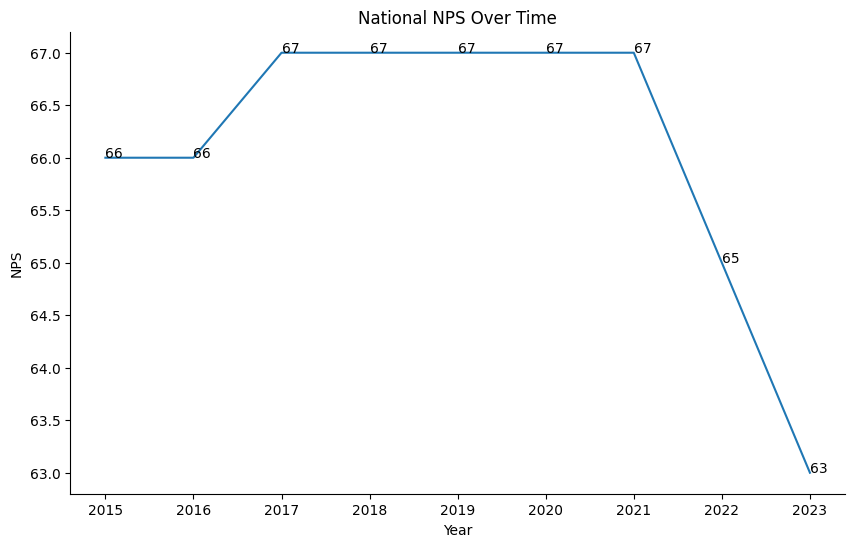

In [5]:
# National NPS over time
# Filter and calculate NPS
national_nps = national_results[national_results['measure_id'] == 'H_RECMND'].copy()
national_nps['nps'] = national_nps['top-box_percentage'] - national_nps['bottom-box_percentage']

# create lineplot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(national_nps,
                  x='release_period',
                  y='nps')
plt.title('National NPS Over Time')
plt.xlabel('Year')
plt.ylabel('NPS')
sns.despine()

#annotate points
for index, row in national_nps.iterrows():
    ax.text(row['release_period'], row['nps'], f"{row['nps']}")

plt.show()

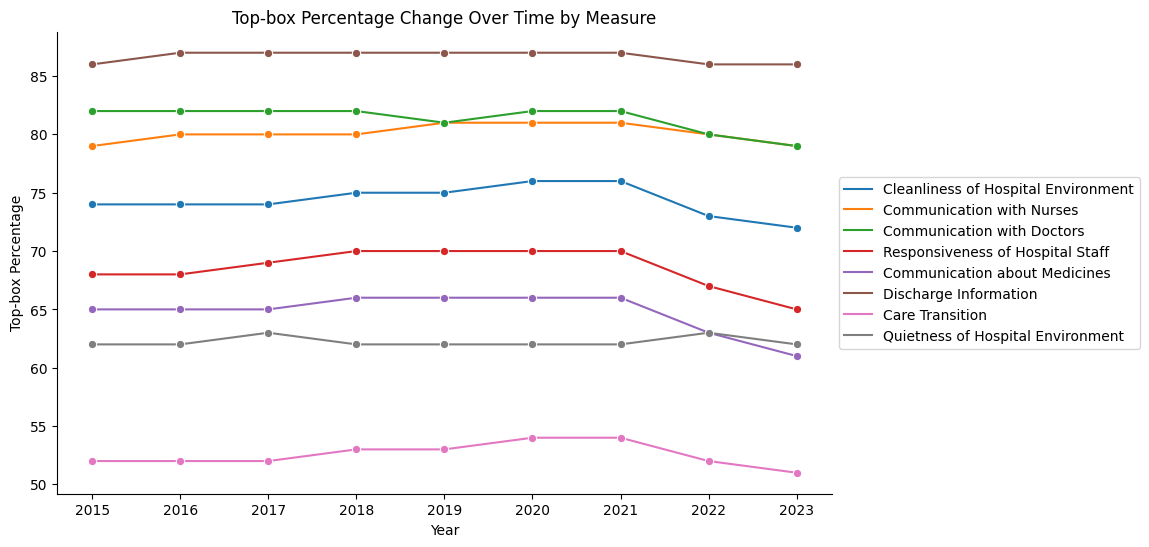

In [6]:
# Top-box percentage change over time by measure
measure_score = national_results[national_results['measure_id'].isin(['H_RECMND', 'H_HSP_RATING']) == False]

# Plot lineplot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(measure_score,
                  x='release_period',
                  y='top-box_percentage',
                  hue='measure',
                  marker='o')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Top-box Percentage Change Over Time by Measure')
plt.xlabel('Year')
plt.ylabel('Top-box Percentage')
sns.despine()
plt.show()

<Figure size 1000x600 with 0 Axes>

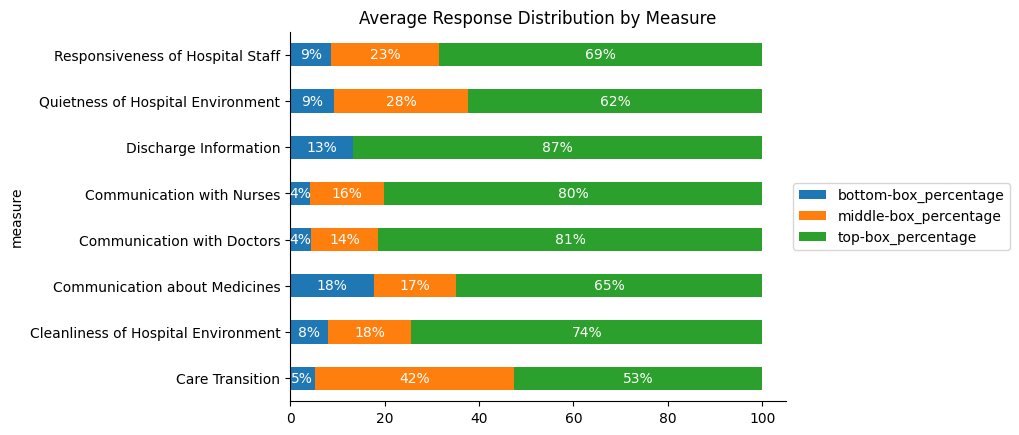

In [10]:
# Average bottom, middle, top box percetage of each measure
national_percentage = national_results[national_results['measure_id'].isin(['H_RECMND', 'H_HSP_RATING']) == False].drop(
    columns=['release_period', 'measure_id']).groupby('measure').mean().reset_index()

# Average response distribution by measure
plt.figure(figsize=(10, 6))
ax = national_percentage.plot(kind='barh',
                              x='measure',
                              stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Average Response Distribution by Measure')
sns.despine()

# Annotate the bars
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width/2 + p.get_x(), 
                p.get_y() + p.get_height()/2, 
                '{:.0f}%'.format(width), 
                ha='center', 
                va='center', 
                color='white')

plt.show()

## State
- To look at the overall scores of each state, the average NPS was calculated and the top 10 NPS and bottom 10 NPS states were plotted on a bar chart. 
- The data was also plotted on a choropleth map to visualize the distribution of NPS across the US.

### Findings
- **South Dakota** had the highest NPS of 76.0%, while **District of Columbia** had the lowest NPS of 50.3%.
- High NPS states were primarily in the **central region**, while low NPS states were primarily in the **mid/south Atlantic region**.


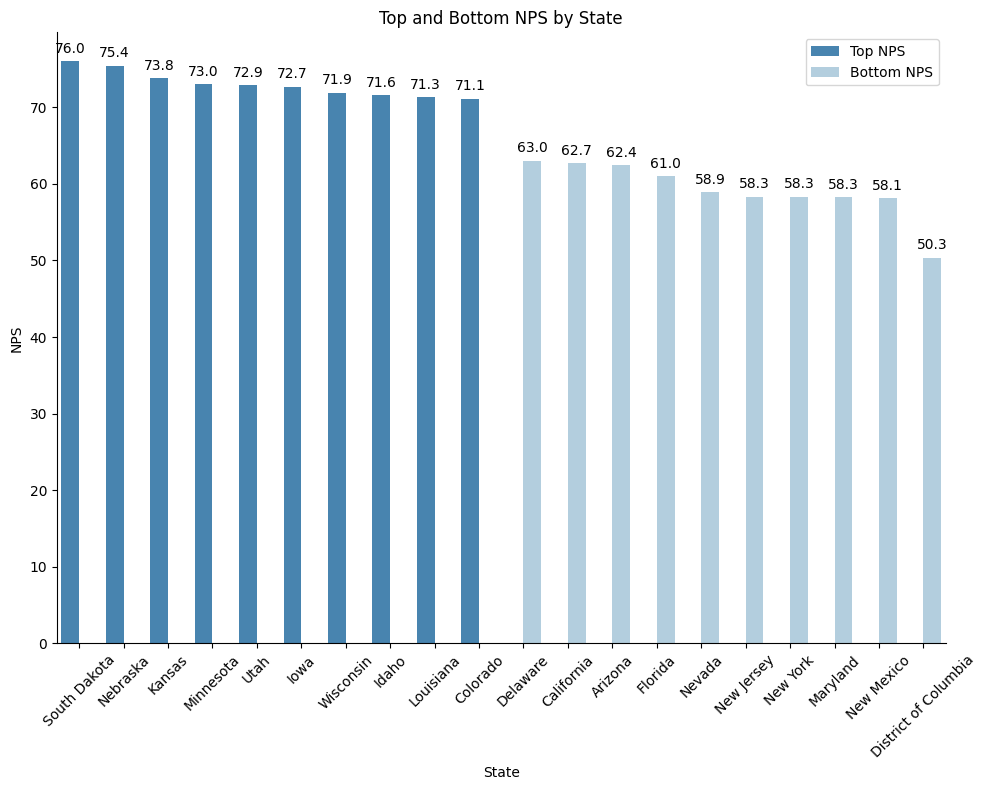

In [19]:
# Prepare data for plot; average NPS by state name
state_name_nps = state_nps.groupby(['state_name'])['nps'].mean().reset_index()

# Sort top and bottom NPS
top_nps = state_name_nps.sort_values('nps', ascending=False).head(10)
bot_nps = state_name_nps.sort_values('nps', ascending=True).head(10)

# Add a label column to differentiate top and bottom states
top_nps['label'] = 'Top NPS'
bot_nps['label'] = 'Bottom NPS'

# Combine top and bottom NPS data
combined_nps = pd.concat([top_nps, bot_nps])

# Sort the combined data for better visualization
combined_nps = combined_nps.sort_values('nps', ascending=False)

# Create the barplot
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=combined_nps, y='nps', x='state_name', hue='label', palette='Blues_r')

# Annotate bars
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9),
                textcoords='offset points')

# modify plot
ax.get_legend().set_title('')
sns.despine()
plt.title("Top and Bottom NPS by State")
plt.xlabel('State')
plt.ylabel('NPS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()



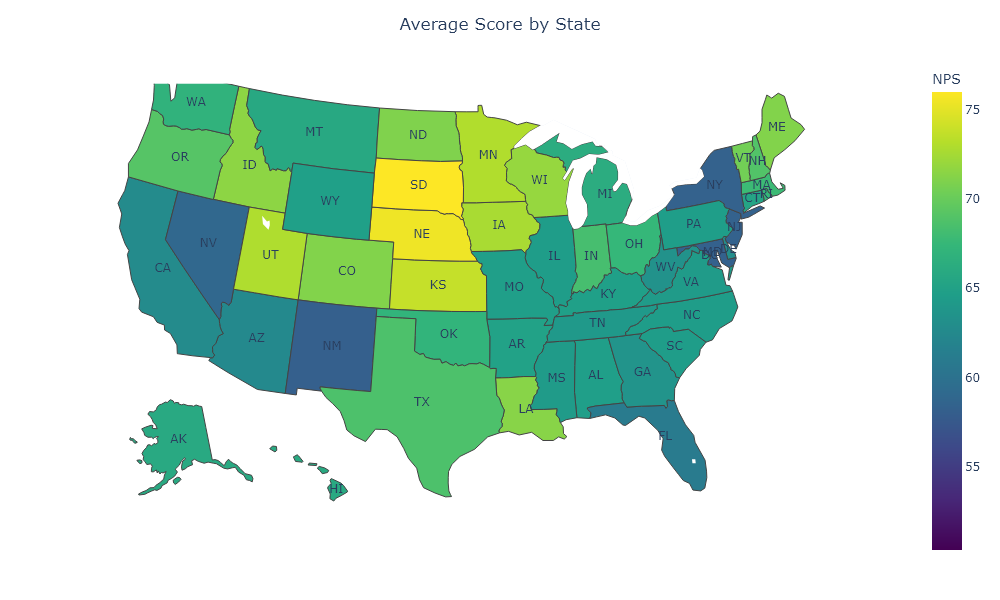

In [20]:
# Prepare data for plot: average state NPS
state_nps = state_nps.groupby(['state'])['nps'].mean().reset_index()

# Plot average state NPS
pio.renderers.default = "png"
trace1 = go.Choropleth(
    locations=state_nps['state'],
    z=state_nps['nps'],
    locationmode='USA-states',
    colorscale='Viridis',
    colorbar_title='NPS'
)
trace2 = go.Scattergeo(
    locations=state_nps['state'],
    locationmode='USA-states',
    text=state_nps['state'],
    mode='text'
)
layout = go.Layout(
    geo=dict(
        scope='usa',
        projection=dict(
            type='albers usa'
        ),
        center=dict(
            lat=37.0902,
            lon=-95.7129
        ),
    ),
    title = 'Average Score by State',
    title_x = 0.5,
    margin = dict(t=60, b=40, l=40, r=40),
    width=1000,
    height=600
)
data = [trace1, trace2]
usmap = go.Figure(data=data, layout=layout)
usmap.show()


## Responses
- To look at the trend of response rates over time, the average response rate was calculated for each year and plotted on a bar chart.

### Findings
- Average national response rate was highest in 2015 at 30.84% and consistently decreased every year to 22.74% in 2023.

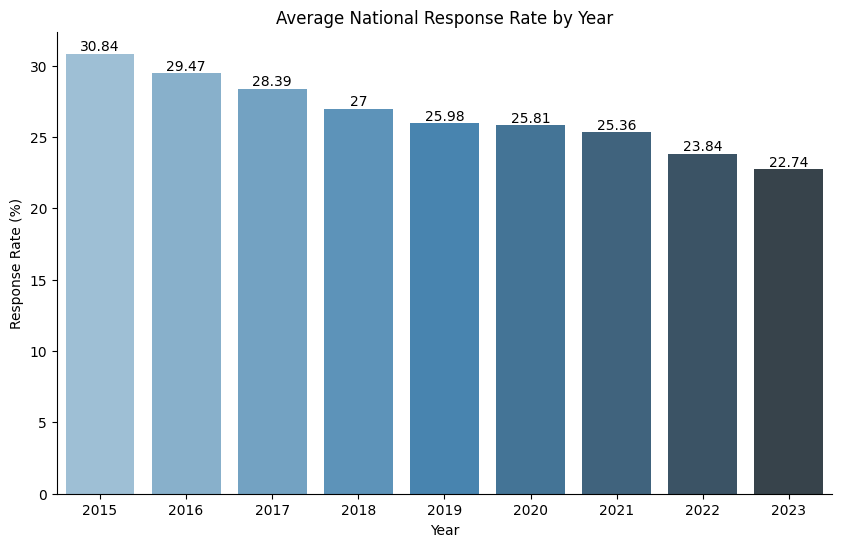

In [5]:
# Plot average national response rate by year
rr = responses[responses.response_rate != 'Not Available'].copy()
rr.response_rate = rr.response_rate.astype('int64')
national_rr = rr.groupby('release_period')[['response_rate']].mean().round(2).reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(national_rr,
                 x='release_period',
                 y='response_rate',
                 palette='Blues_d')
plt.title('Average National Response Rate by Year')
plt.xlabel('Year')
plt.ylabel('Response Rate (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# annoate bars
for label in ax.containers:
    ax.bar_label(label)
plt.show()

## Summary
- The NPS increased slightly in 2017, then remained unchanged until 2021 where a sharp decline was observed. 
- **Discharge Information** had the highest average top-box percentage at 87%, while **Care Transition** had the lowest average top-box percentage at 53%.
- The **Discharge Information** measure had no middle box responses, while **Care Transition** had the highest average middle box percentage of 42%.
- **Communication about Medicines** had the highest average bottom-box percentage at 18%, while **Communication with Nurses** and **Communication with Doctors** had the lowest average bottom-box percentage at 4%.
- **South Dakota** had the highest NPS of 76.0%, while **District of Columbia** had the lowest NPS of 50.3%.
- High NPS states were primarily in the **central region**, while low NPS states were primarily in the **mid/south atlantic region**.
- Average national response rate was highest in 2015 at 30.84% and consistently decreased every year to 22.74% in 2023.

## Recommendations
- **Focus on care transition**: Providing patients and their families with a detailed care plan can ensure a smooth transition after being discharged from the hospital. Consider implementing dedicated teams or individuals responsible for managing transitions who can provide clear instructions for outpatient follow up care and address any questions or concerns. 
- **Improve communication about medications**: Ensuring patients are properly educated about their medications can improve patient satisfaction as well as care transition. Implement or enhance a medication reconciliation process to ensure that patients understand the purpose, dosage, side effects, and potential interactions of their medications.
- **Regional Differences**: Focus on improving patient experience in the mid/south Atlantic region. Hospitals with high NPS scores in the central region could share best practices and identify specific issues or challenges faced by hospitals in the mid/south Atlantic region.
- **Increase response rate**: The decreasing response rate over the years indicates reduced patient engagement in providing feedback. Consider simplifying the survey process by using a digital platform such as a mobile app or online portal. 